In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from colors import colors5, colors3, colors2

# LaTeX formatted figures
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 15,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

# Common figure variables
STL = ['-', '--', ':', '-.']  # Styles
MRK = ['o', '*', '^', 's']    # Markers
MRS = [6, 8, 6, 6]            # Marker styles

In [2]:
spectral_decays = np.load("../results/spectral_decays.npz")
results_small   = np.load("../results/results_small.npz")
results_medium  = np.load("../results/results_medium.npz")
results_large   = np.load("../results/results_large.npz")

results_all = {
    "small": results_small,
    "medium": results_medium,
    "large": results_large
}

k_min, k_max = 5, 50
cond_numbers = [2, 50, 1000]
k_range = np.arange(k_min, k_max)
fig_path = "../figures/"

In [3]:
def get_medians(results):
    # Take the median over the (ns, nr) axis, i.e.
    # the spectral decays and the ranks k_min to k_max
    t_vars = ('t rsvd', 't rsvdT', 't svd', 't svdT')
    medians = {
        t_var: np.median(results[t_var], axis=(0, 1))
        for t_var in t_vars
    }
    return medians


def get_speedups(results_all):
    # speedups layout:
    #{
    #    'small': {'rsvd': ..., 'rsvdT': ...},
    #    'medium': {'rsvd': ..., 'rsvdT': ...},
    #    'large': {'rsvd': ..., 'rsvdT': ...}
    #}
    sizes = ("small", "medium", "large")

    medians_all = {size: get_medians(results_all[size]) for size in sizes}
    speedups = {}
    for size in sizes:
        medians = medians_all[size]
        speedups_size = {
            'rsvd': medians['t svd'] / medians['t rsvd'],
            'rsvdT': medians['t svdT'] / medians['t rsvdT']
        }
        speedups[size] = speedups_size
    return speedups

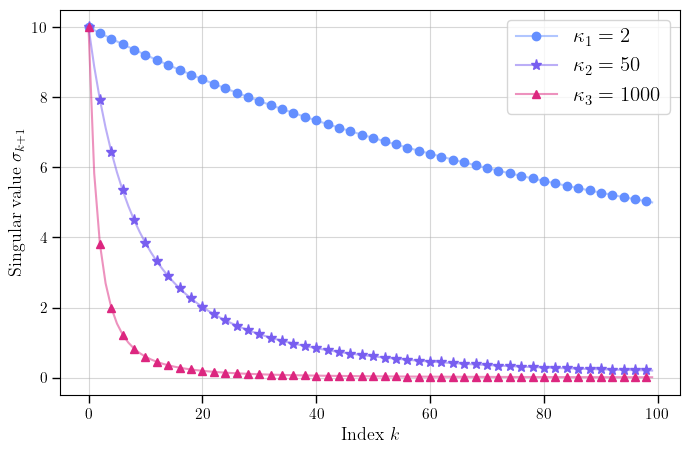

In [4]:
def make_line_marker_legend_handle(
        c, m='None', ms=6, ls='-',
        lw=1.5, alpha_line=1.0, label=None
    ):
    """
    Create a (line, marker) tuple handle for matplotlib legends.
    """
    legend_line = Line2D([0], [0], color=c, linestyle=ls, linewidth=lw, alpha=alpha_line)
    legend_marker = Line2D([0], [0], color=c, marker=m, markersize=ms, linestyle='None')
    return (legend_line, legend_marker), label


def plot_spectral_decays(spectral_decays, fig_name):
    # Plot the spectral decays of the "Small case"
    sing_values = spectral_decays["small"]
    N = sing_values.shape[1]

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    step = 2
    handles, labels = [], []
    for i in range(3):
        ax.plot(
            np.arange(N)[::step], sing_values[i][::step],
            MRK[i], c=colors3[i], ms=MRS[i])
        ax.plot(
            np.arange(N), sing_values[i],
            '-', c=colors3[i], ms=1, alpha=0.5)

        handle, label = make_line_marker_legend_handle(
            c=colors3[i], m=MRK[i], ms=MRS[i], alpha_line=0.5,
            label=f'$\\kappa_{{{i+1}}}={cond_numbers[i]}$')
        handles.append(handle)
        labels.append(label)

    ax.set_xlabel('Index $k$', fontsize=13)
    ax.set_ylabel('Singular value $\\sigma_{k+1}$', fontsize=13)

    ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
    ax.tick_params(axis='both', which='minor', length=3, color='gray')

    ax.grid(True, alpha=0.5)
    ax.legend(handles=handles, labels=labels)
    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()


plot_spectral_decays(spectral_decays, "singular_value_decay.png")

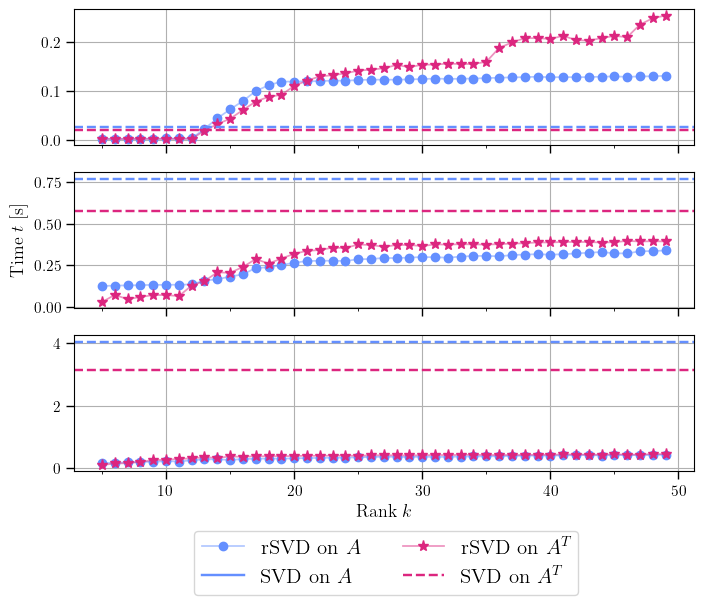

In [5]:
def plot_results(results, fig_name=None):
    """
    One plot comparing the computation times on rSVD and SVD
    for a given matrix size.
    """
    medians = get_medians(results)

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Matrix A
    ax.plot(
        k_range, medians['t rsvd'],
        c=colors2[0], lw=1.5,
        marker=MRK[0], ms=MRS[0],
        label=r"rSVD ($A$)")
    ax.axhline(
        medians['t svd'],
        c=colors2[0], lw=2, ls='--',
        label=r"SVD ($A$)")

    # Matrix A^T
    ax.plot(
        k_range, medians['t rsvdT'],
        c=colors2[1], lw=1.5,
        marker=MRK[1], ms=MRS[1],
        label=r"rSVD ($A^T$)")
    ax.axhline(
        medians['t svdT'],
        c=colors2[1], lw=2, ls=':',
        label=r"SVD ($A^T$)")
    
    ax.set_xlabel(r'Rank $k$', fontsize=13)
    ax.set_ylabel(r'$t$ [s]', fontsize=13)

    # Modify ticks
    ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
    ax.xaxis.set_minor_locator(MultipleLocator(5))

    ax.grid(True)
    ax.legend()
    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()


def plot_results_broken(results, fig_name=None, y_lims=None):
    """
    One plot comparing the computation times on rSVD and SVD
    with a 'broken y-axis' or a given matrix size.
    """
    medians = get_medians(results)

    if y_lims is None:
        y_lims = ((0, .59), (2.1, 5.5))

    # Break plot into 2 parts
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
    fig.subplots_adjust(hspace=0.05)

    for ax in (ax1, ax2):
        # Matrix A
        ax.plot(
            k_range, medians['t rsvd'],
            c=colors2[0], lw=1.5,
            marker=MRK[0], ms=MRS[0],
            label=r"rSVD ($A$)")
        ax.axhline(
            medians['t svd'],
            c=colors2[0], lw=2, ls='--',
            label=r"SVD ($A$)")

        # Matrix A^T
        ax.plot(
            k_range, medians['t rsvdT'],
            c=colors2[1], lw=1.5,
            marker=MRK[1], ms=MRS[1],
            label=r"rSVD ($A^T$)")
        ax.axhline(
            medians['t svdT'],
            c=colors2[1], lw=2, ls=':',
            label=r"SVD ($A^T$)")


        # Modify ticks and grid
        ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
        ax.grid(True)

    # Limit top and bottom ranges
    ax1.set_ylim(y_lims[1])
    ax2.set_ylim(y_lims[0])

    # Hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    ax2.xaxis.tick_bottom()
    #ax2.xaxis.set_minor_locator(MultipleLocator(5))

    # Modify ticks
    ax1.tick_params(axis='x', which='both', top=False)
    ax2.xaxis.set_minor_locator(MultipleLocator(5))
    
    # Slanted lines
    d = .3
    kwargs = dict(
        marker=[(-1, -d), (1, d)], markersize=12,
        linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    ax2.set_xlabel('Rank $k$', fontsize=13)
    ax2.set_ylabel('$t$ [s]', fontsize=13)

    ax1.legend(loc="upper right")
    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()


def plot_all_times_tall(results_all, fig_name=None):
    medians_all = {
        size: get_medians(results_all[size])  # {'t rsvd': , 't rsvdT': , 't svd': , 't svdT': }
        for size in ('small', 'medium', 'large')
    }

    fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    ax1, ax2, ax3 = axs

    for i, (size, medians) in enumerate(medians_all.items()):
        ax = axs[i]

        ax.plot(  # Marker, rSVD on A
            k_range, medians['t rsvd'],
            MRK[0], c=colors2[0], ms=MRS[0])
        ax.plot(  # Transparent line, rSVD on A
            k_range, medians['t rsvd'],
            '-', c=colors2[0], lw=1.25, alpha=.5)
        ax.plot(  # Marker, rSVD on A^T
            k_range, medians['t rsvdT'],
            MRK[1], c=colors2[1], ms=MRS[1])
        ax.plot(  # Transparent line, rSVD on A^T
            k_range, medians['t rsvdT'],
            '-', c=colors2[1], lw=1.25, alpha=.5)
        ax.axhline(  # Line, SVD on A
            medians['t svd'], c=colors2[0], lw=1.75,
            ls='--')
        ax.axhline(  # Line, SVD on A^T
            medians['t svdT'], c=colors2[1], lw=1.75,
            ls='--')

        ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.grid(True)

    # Custom labels
    handles, labels = [], []
    for i, A in enumerate(('A', 'A^T')):
        # rSVD (marker + line)
        h1, l1 = make_line_marker_legend_handle(
            c=colors2[i], m=MRK[i], ms=MRS[i], alpha_line=0.5, lw=1.25,
            label=fr'rSVD on ${{{A}}}$')

        # SVD (line only)
        h2, l2 = make_line_marker_legend_handle(
            c=colors2[i], ls=STL[i], lw=1.75,
            label=fr'SVD on ${{{A}}}$')
        
        handles.extend([h1, h2]); labels.extend([l1, l2])


    ax3.set_xlabel(r'Rank $k$', fontsize=13)
    ax2.set_ylabel(r'Time $t$ [s]', fontsize=13)
    ax3.legend(
        handles=handles, labels=labels,
        loc='upper right', ncols=2, bbox_to_anchor=(0.83, -0.36)
    )

    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()


def plot_all_times_wide(results_all, fig_name=None):
    medians_all = {
        size: get_medians(results_all[size])  # {'t rsvd': , 't rsvdT': , 't svd': , 't svdT': }
        for size in ('small', 'medium', 'large')
    }

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    ax1, ax2, ax3 = axs

    for i, (size, medians) in enumerate(medians_all.items()):
        ax = axs[i]

        ax.plot(  # Marker, rSVD on A
            k_range, medians['t rsvd'],
            MRK[0], c=colors2[0], ms=MRS[0])
        ax.plot(  # Transparent line, rSVD on A
            k_range, medians['t rsvd'],
            '-', c=colors2[0], lw=1.25, alpha=.5)
        ax.plot(  # Marker, rSVD on A^T
            k_range, medians['t rsvdT'],
            MRK[1], c=colors2[1], ms=MRS[1])
        ax.plot(  # Transparent line, rSVD on A^T
            k_range, medians['t rsvdT'],
            '-', c=colors2[1], lw=1.25, alpha=.5)
        ax.axhline(  # Line, SVD on A
            medians['t svd'], c=colors2[0], lw=1.75,
            ls='--')
        ax.axhline(  # Line, SVD on A^T
            medians['t svdT'], c=colors2[1], lw=1.75,
            ls='--')

        ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.grid(True)

    # Custom labels
    handles, labels = [], []
    for i, A in enumerate(('A', 'A^T')):
        # rSVD (marker + line)
        h1, l1 = make_line_marker_legend_handle(
            c=colors2[i], m=MRK[i], ms=MRS[i], alpha_line=0.5, lw=1.25,
            label=fr'rSVD on ${{{A}}}$')

        # SVD (line only)
        h2, l2 = make_line_marker_legend_handle(
            c=colors2[i], ls=STL[i], lw=1.75,
            label=fr'SVD on ${{{A}}}$')
        
        handles.extend([h1, h2]); labels.extend([l1, l2])


    ax2.set_xlabel(r'Rank $k$', fontsize=13)
    ax1.set_ylabel(r'Time $t$ [s]', fontsize=13)
    ax3.legend(
        handles=handles, labels=labels,
        loc='upper right', ncols=2, bbox_to_anchor=(0.4, -0.12)
    )

    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()

#plot_all_times_wide(results_all)
plot_all_times_tall(results_all, "timing_all.png")


In [6]:
#plot_results(results_small, "comparison_small.png")
#plot_results(results_medium, "comparison_medium.png")
#plot_results_broken(results_large, "time_comparison_large.png")

In [7]:
def plot_speedup(results_all, which, fig_name=None):
    speedup = get_speedups(results_all)[which]

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Matrix A
    ax.semilogy(
        k_range, speedup['rsvd'],
        c=colors2[0], lw=1.5,
        marker=MRK[0], ms=MRS[0],
        label=r"rSVD on $A$")

    # Matrix A^T
    ax.semilogy(
        k_range, speedup['rsvdT'],
        c=colors2[1], lw=1.5,
        marker=MRK[1], ms=MRS[1],
        label=r"rSVD on $A^T$")

    ax.axhline(1, c='black', lw=1, ls='--')

    ax.set_xlabel('Rank $k$', fontsize=13)
    ax.set_ylabel('$t$ [s]', fontsize=13)

    # Modify ticks
    ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
    ax.xaxis.set_minor_locator(MultipleLocator(5))

    ax.grid(True)
    ax.legend()
    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()

#plot_speedup(results_all, 'small')

$$
t_{\text{wide}} / t_{\text{tall}}
$$

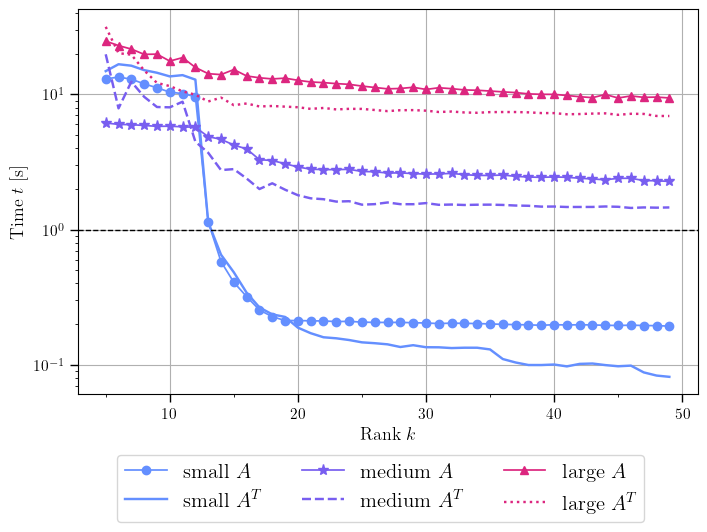

In [8]:
def plot_all_speedups(results_all, fig_name=None):
    speedups = get_speedups(results_all)

    # Plot in one axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    for i, (size, speedup) in enumerate(speedups.items()):
        # Speedup on matrix A
        ax.semilogy(
            k_range, speedup['rsvd'],
            c=colors3[i], lw=1.25,
            marker=MRK[i], ms=MRS[i],
            label=fr"{size} $A$")

        # Speedup on matrix A^T
        ax.semilogy(
            k_range, speedup['rsvdT'],
            c=colors3[i], lw=1.75,
            ls=STL[i],
            label=fr"{size} $A^T$")

    ax.axhline(1, c='black', lw=1, ls='--')

    ax.set_xlabel('Rank $k$', fontsize=13)
    ax.set_ylabel('Time $t$ [s]', fontsize=13)

    # Modify ticks
    ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
    ax.xaxis.set_minor_locator(MultipleLocator(5))

    ax.grid(True)
    ax.legend(bbox_to_anchor=(0.93, -0.13), loc='upper right', ncols=3)
    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()


plot_all_speedups(results_all, "speedups_all.png")

In [9]:
speedup_wide_vs_tall = {}
for size in results_all.keys():
    times = results_all[size]
    print(list(times.keys()))
    speedup = times['t rsvdT'] / times['t rsvd']  # shape (3, nr, nk)
    speedup_wide_vs_tall[size] = speedup.mean(axis=(0, 1))

['t rsvd', 't rsvdT', 't svd', 't svdT', 'e rsvd', 'e rsvdT']
['t rsvd', 't rsvdT', 't svd', 't svdT', 'e rsvd', 'e rsvdT']
['t rsvd', 't rsvdT', 't svd', 't svdT', 'e rsvd', 'e rsvdT']


In [10]:
speedup_wide_vs_tall['small'].shape

(45,)

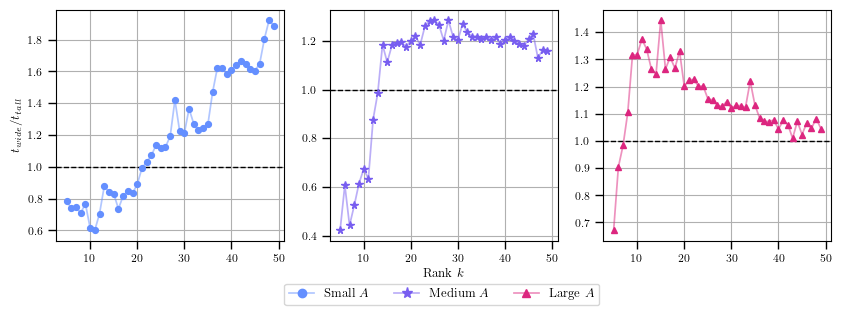

In [11]:
def plot_wide_vs_tall(speedup_wide_vs_tall, fig_name=None):
    labelsize = 8
    fontsize = 9
    fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

    # Matrix A
    handles, labels = [], []
    for i, size in enumerate(('small', 'medium', 'large')):
        ax = axs[i]
        ax.axhline(1.0, ls='--', lw=1, c='black')
        ax.plot(
            k_range, speedup_wide_vs_tall[size],
            MRK[i], c=colors3[i], ms=MRS[i]*0.7)
        ax.plot(
            k_range, speedup_wide_vs_tall[size],
            '-', alpha=0.5, c=colors3[i], lw=1.25)

        # Modify ticks
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        ax.tick_params(axis='both', which='major', labelsize=labelsize, length=6, width=1)
        ax.grid(True)

        h1, l1 = make_line_marker_legend_handle(
            c=colors3[i], m=MRK[i], ms=MRS[i], alpha_line=0.5, lw=1.25,
            label=f'{size.capitalize()} $A$')
        handles.extend([h1]); labels.extend([l1])

    axs[1].set_xlabel(r'Rank $k$', fontsize=fontsize)
    axs[0].set_ylabel(r'$t_{wide} / t_{tall}$', fontsize=fontsize)

    axs[1].legend(
        handles=handles, labels=labels, ncols=3, bbox_to_anchor=(1.21, -0.16), fontsize=fontsize)
    if fig_name is not None:
        plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight')
    plt.show()


plot_wide_vs_tall(speedup_wide_vs_tall, "wide_versus_tall.png")

In [12]:
def get_average_errors(results_all, spectral_decays):
    errors_all = {}
    for size in ('small', 'medium', 'large'):
        errors_all[size] = {
            'e rsvd': results_all[size]['e rsvd'].mean(axis=1),
            'e rsvdT': results_all[size]['e rsvd'].mean(axis=1),
            'e svd': spectral_decays[size][:, k_min:k_max],
            'e svdT': spectral_decays[size][:, k_min:k_max]
        }
    return errors_all


errors_all = get_average_errors(results_all, spectral_decays)

axs[0][0] : small, slow
axs[0][1] : small, moderate
axs[0][2] : small, rapid
axs[1][0] : medium, slow
axs[1][1] : medium, moderate
axs[1][2] : medium, rapid
axs[2][0] : large, slow
axs[2][1] : large, moderate
axs[2][2] : large, rapid


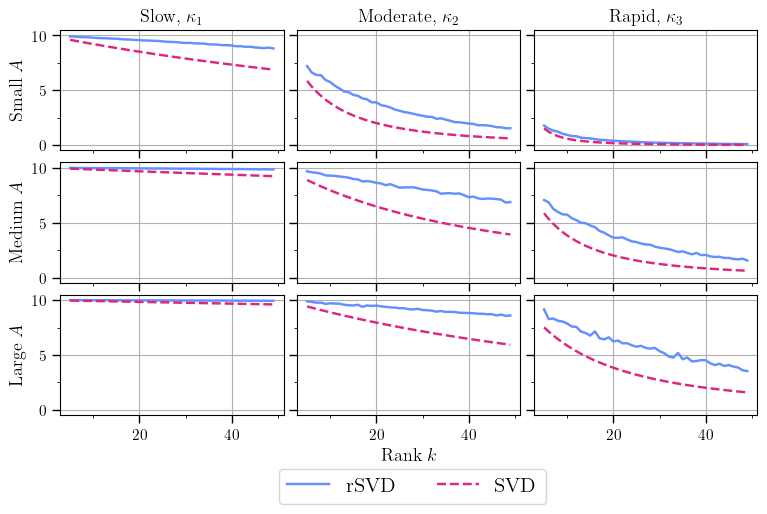

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(9, 5), sharex=True, sharey=True)

for i, size in enumerate(('small', 'medium', 'large')):
    for j, decay in enumerate(('slow', 'moderate', 'rapid')):
        print(f"axs[{i}][{j}] : {size}, {decay}")
        ax = axs[i][j]
        errors = errors_all[size]['e rsvd'][j]
        ax.plot(
            k_range, errors, '-',
            c=colors2[0], lw=1.75,
            label=r"rSVD ($A$)")
        
        errors_svd = errors_all[size]['e svd'][j]
        ax.plot(
            k_range, errors_svd, '--',
            c=colors2[1], lw=1.75,
            label=r"rSVD ($A$)")
        
        ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(2.5))
        ax.grid(True)


axs[2][1].set_xlabel(r'Rank $k$', fontsize=13)

axs[0][0].set_title(r"Slow, $\kappa_1$", fontsize=13)
axs[0][1].set_title(r"Moderate, $\kappa_2$", fontsize=13)
axs[0][2].set_title(r"Rapid, $\kappa_3$", fontsize=13)

axs[0][0].set_ylabel(r"Small $A$", fontsize=13)
axs[1][0].set_ylabel(r"Medium $A$", fontsize=13)
axs[2][0].set_ylabel(r"Large $A$", fontsize=13)

# Custom labels
handles, labels = [], []
h1, l1 = make_line_marker_legend_handle(c=colors2[0], lw=1.75, label='rSVD')
h2, l2 = make_line_marker_legend_handle(c=colors2[1], lw=1.75, ls='--', label='SVD')
handles.extend([h1, h2]); labels.extend([l1, l2])


axs[2][1].legend(
    handles=handles, labels=labels,
    loc='upper right', ncols=2, bbox_to_anchor=(1.16, -0.36))
plt.subplots_adjust(wspace=0.06, hspace=0.1)
plt.savefig(fig_path + "errors_raw.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
errors_relative = {}
for i, (size, errors) in enumerate(errors_all.items()):
    e_rsvd = errors['e rsvd']
    e_svd = errors['e svd']
    errors_relative[size] = errors['e rsvd'] / errors['e svd']


axs[0][0] : small, slow
axs[0][1] : small, moderate
axs[0][2] : small, rapid
axs[1][0] : medium, slow
axs[1][1] : medium, moderate
axs[1][2] : medium, rapid
axs[2][0] : large, slow
axs[2][1] : large, moderate
axs[2][2] : large, rapid


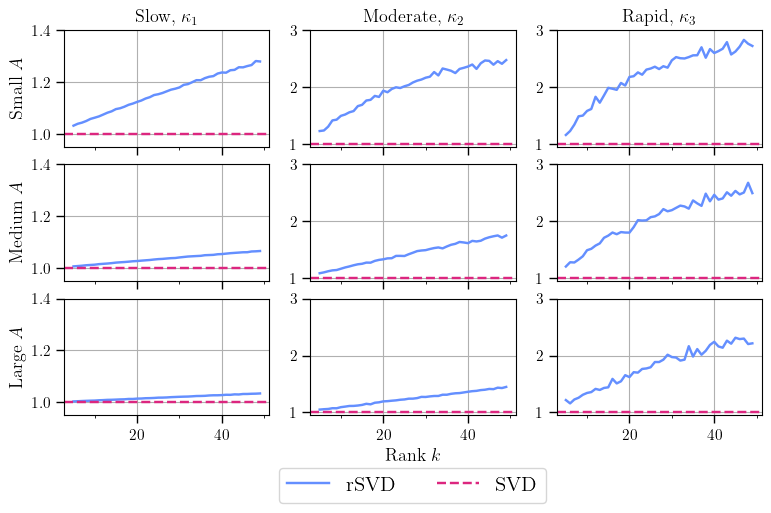

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(9, 5), sharex=True)

for i, size in enumerate(('small', 'medium', 'large')):
    for j, decay in enumerate(('slow', 'moderate', 'rapid')):
        print(f"axs[{i}][{j}] : {size}, {decay}")
        ax = axs[i][j]

        relative = errors_relative[size][j]

        ax.plot(
            k_range, relative, '-',
            c=colors2[0], lw=1.75,
            label=r"rSVD ($A$)")
        
        ax.axhline(1, lw=1.75, ls='--', c=colors2[1])

        
        ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        #ax.yaxis.set_minor_locator(MultipleLocator(25))
        #ax.yaxis.set_major_locator(MultipleLocator(50))
        ax.grid(True)


for i in range(3):
    axs[i][0].set_ylim(0.95, 1.40)
    axs[i][0].yaxis.set_major_locator(MultipleLocator(0.2))

    axs[i][1].set_ylim(0.95, 3.00)
    axs[i][1].yaxis.set_major_locator(MultipleLocator(1.00))

    axs[i][2].set_ylim(0.95, 3.00)
    axs[i][1].yaxis.set_major_locator(MultipleLocator(1.00))

axs[2][1].set_xlabel(r'Rank $k$', fontsize=13)

axs[0][0].set_title(r"Slow, $\kappa_1$", fontsize=13)
axs[0][1].set_title(r"Moderate, $\kappa_2$", fontsize=13)
axs[0][2].set_title(r"Rapid, $\kappa_3$", fontsize=13)

axs[0][0].set_ylabel(r"Small $A$", fontsize=13)
axs[1][0].set_ylabel(r"Medium $A$", fontsize=13)
axs[2][0].set_ylabel(r"Large $A$", fontsize=13)


# Custom labels
handles, labels = [], []
h1, l1 = make_line_marker_legend_handle(c=colors2[0], lw=1.75, label='rSVD')
h2, l2 = make_line_marker_legend_handle(c=colors2[1], lw=1.75, ls='--', label='SVD')
handles.extend([h1, h2]); labels.extend([l1, l2])


axs[2][1].legend(
    handles=handles, labels=labels,
    loc='upper right', ncols=2, bbox_to_anchor=(1.2, -0.36))
plt.subplots_adjust(wspace=0.2, hspace=0.15)
plt.savefig(fig_path + "errors_relative.png", dpi=300, bbox_inches='tight')
plt.show()